# <font color='red'>**Sequence to sequence implementation**</font>

**There will be some functions that start with the word "grader" ex: grader_check_encoder(), grader_check_attention(), grader_onestepdecoder() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Note 1:**  There are many blogs on the attention mechanisum which might be misleading you,
 so do read the references completly and after that only please check the internet.
 The best things is to read the research papers and try to implement it on your own. 

**Note 2:** To complete this assignment, the reference that are mentioned will be enough.

**Note 3:** If you are starting this assignment, you might have completed minimum of 20 assignment.
 If  you are still not able to implement this algorithm you might have rushed in the previous assignments 
with out learning much and didn't spend your time productively.

## Task -1: Simple Encoder and Decoder
Implement simple Encoder-Decoder model

1. Download the **Italian** to **English** translation dataset from <a href="http://www.manythings.org/anki/ita-eng.zip">here</a>

2. You will find **ita.txt** file in that ZIP, 
you can read that data using python and preprocess that data this way only: 
<img src='https://i.imgur.com/z0j79Jf.png'>    
    
3. You have to implement a simple Encoder and Decoder architecture  

4. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

5. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

6.  a. Check the reference notebook <br>
    b. <a href="https://medium.com/analytics-vidhya/understand-sequence-to-sequence-models-in-a-more-intuitive-way-1d517d8795bb">Resource 2</a>
    



In [1]:
!nvidia-smi

Sun May 30 14:35:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Reshape, Softmax, Dot, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import seaborn as sns

<font color='blue'>**Load the data**</font>

In [3]:
!wget http://www.manythings.org/anki/ita-eng.zip
!unzip ita-eng.zip

--2021-05-30 14:35:11--  http://www.manythings.org/anki/ita-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.21.55.222, 172.67.173.198, 2606:4700:3031::6815:37de, ...
Connecting to www.manythings.org (www.manythings.org)|104.21.55.222|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7567445 (7.2M) [application/zip]
Saving to: ‘ita-eng.zip’

ita-eng.zip         100%[===================>]   7.22M  6.63MB/s    in 1.1s    

2021-05-30 14:35:13 (6.63 MB/s) - ‘ita-eng.zip’ saved [7567445/7567445]

Archive:  ita-eng.zip
  inflating: ita.txt                 
  inflating: _about.txt              


In [4]:
with open('ita.txt', 'r', encoding="utf8") as f:
    eng=[]
    ita=[]
    for i in f.readlines():
        eng.append(i.split("\t")[0])
        ita.append(i.split("\t")[1])
data = pd.DataFrame(data=list(zip(eng, ita)), columns=['english','italian'])
print(data.shape)
data.head()

(345244, 2)


,english,italian
0,Hi.,Ciao!
1,Run!,Corri!
2,Run!,Corra!
3,Run!,Correte!
4,Who?,Chi?


<font color='blue'>**Preprocess data**</font>

In [5]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

def preprocess_ita(text):
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text


data['english'] = data['english'].apply(preprocess)
data['italian'] = data['italian'].apply(preprocess_ita)
data.head()

,english,italian
0,Hi,ciao
1,Run,corri
2,Run,corra
3,Run,correte
4,Who,chi


In [6]:
ita_lengths = data['italian'].str.split().apply(len)
eng_lengths = data['english'].str.split().apply(len)

In [7]:
data['italian_len'] = data['italian'].str.split().apply(len)
data = data[data['italian_len'] < 20]

data['english_len'] = data['english'].str.split().apply(len)
data = data[data['english_len'] < 20]

data['english_inp'] = '<start> ' + data['english'].astype(str)
data['english_out'] = data['english'].astype(str) + ' <end>'

data = data.drop(['english','italian_len','english_len'], axis=1)
# only for the first sentance add a toke <end> so that we will have <end> in tokenizer
data.head()

,italian,english_inp,english_out
0,ciao,<start> Hi,Hi <end>
1,corri,<start> Run,Run <end>
2,corra,<start> Run,Run <end>
3,correte,<start> Run,Run <end>
4,chi,<start> Who,Who <end>


In [8]:
data.sample(10)

,italian,english_inp,english_out
122311,la radio non funziona,<start> The radio does not work,The radio does not work <end>
69375,tu non sei serio,<start> You are not serious,You are not serious <end>
110414,noi non possiamo trainare questa macchina,<start> We can not tow this car,We can not tow this car <end>
25459,ehi posso aiutare,<start> Hey can I help,Hey can I help <end>
255524,tom se ne occuperà,<start> Tom is going to take care of it,Tom is going to take care of it <end>
174528,voi dovete essere ottimisti,<start> You have to be optimistic,You have to be optimistic <end>
81155,faremmo meglio ad andare tom,<start> We would better go Tom,We would better go Tom <end>
12494,li avevo dimenticati,<start> I forgot them,I forgot them <end>
219050,quando avete finito il lavoro,<start> When did you finish the work,When did you finish the work <end>
201622,tom è qui per proteggere mary,<start> Tom is here to protect Mary,Tom is here to protect Mary <end>


## Tokenizer

In [9]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.2)

In [10]:
print(train.shape, validation.shape)
# for one sentence we will be adding <end> token so that the tokanizer learns the word <end>
# with this we can use only one tokenizer for both encoder output and decoder output
train.iloc[0]['english_inp']= str(train.iloc[0]['english_inp'])+' <end>'
train.iloc[0]['english_out']= str(train.iloc[0]['english_out'])+' <end>'

(275852, 3) (68964, 3)


In [11]:
train.head()

,italian,english_inp,english_out
311020,tutte le mie figlie vogliono andare a boston,<start> All of my children want to go to Bosto...,All of my children want to go to Boston <end> ...
106806,dica a tom che non sono a casa,<start> Tell Tom I am not home,Tell Tom I am not home <end>
124058,tom non è più vivo,<start> Tom is no longer alive,Tom is no longer alive <end>
138134,ti staranno guardando,<start> They will be watching you,They will be watching you <end>
7312,chiami qualcuno,<start> Call someone,Call someone <end>


In [92]:
tknizer_ita = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_ita.fit_on_texts(train['italian'].values)
tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['english_inp'].values)

In [93]:
train['italian'].values

array(['tutte le mie figlie vogliono andare a boston',
       'dica a tom che non sono a casa', 'tom non è più vivo', ...,
       'sono molto felice di incontrarla oggi', 'sembrate intelligenti',
       'ci hanno trattati come persone di famiglia'], dtype=object)

In [94]:
vocab_size_eng=len(tknizer_eng.word_index.keys())
print(vocab_size_eng)
vocab_size_ita=len(tknizer_ita.word_index.keys())
print(vocab_size_ita)

12816
26224


In [91]:
tknizer_eng.word_index['<start>'], tknizer_eng.word_index['<end>']

(1, 10103)

In [ ]:
!wget https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt

--2021-05-26 08:40:23--  https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ddkmtqz01jc024u/glove.6B.100d.txt [following]
--2021-05-26 08:40:24--  https://www.dropbox.com/s/raw/ddkmtqz01jc024u/glove.6B.100d.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc42d30e4f55c7000b9573f4972.dl.dropboxusercontent.com/cd/0/inline/BPOEuc_DvZ_syGkCJmLjYCCgMQYfrtBdyNtbcfPTGHpvk3Tp8vqEhZdlFWXB5YAfZ8w-6bJZWNKGY0vnm2vu4UQkTS-Mhw0qXH_WECa0FKu6F3Owyiof00ZpnVrhzk_pDbZhzezcQzMwb3r1ktBf7JCs/file# [following]
--2021-05-26 08:40:25--  https://ucc42d30e4f55c7000b9573f4972.dl.dropboxusercontent.com/cd/0/inline/BPOEuc_DvZ_syGkCJmLjYCCgMQYfrtBdyNtbcfPTGHpvk3Tp8vqEhZdlFWXB5YAfZ8w-6bJZW

In [ ]:
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((vocab_size_eng+1, 100))
for word, i in tknizer_eng.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## <font color='blue'>**Implement custom encoder decoder**</font>

In [16]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [ ]:
print(len(tknizer_ita.word_counts))
print(len(tknizer_eng.word_counts))

26300
12887


In [ ]:
train_dataset = Dataset(train, tknizer_ita, tknizer_eng, 20)
test_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, 20)

train_dataloader = Dataloder(train_dataset, batch_size=1024)
test_dataloader = Dataloder(test_dataset, batch_size=1024)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

# train_dataloader[0][0][0] -> eng_input (not available in testing)
# train_dataloader[0][0][0] -> eng_out (sentence to predict)

(1024, 20) (1024, 20) (1024, 20)


<font color='blue'>**Encoder**</font>

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        #Initialize Embedding layer
        #Intialize Encoder LSTM layer
        super().__init__()
        self.inp_vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.input_length = input_length
        self.lstm_units= lstm_size
        self.lstm_output = 0
        self.lstm_state_h=0
        self.lstm_state_c=0
        
    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.inp_vocab_size, output_dim=self.embedding_size, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_encoder")
        self.lstm = LSTM(self.lstm_units, return_state=True, return_sequences=True, name="Encoder_LSTM")


    def call(self,input_sequence,states=[]):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- encoder_output, last time step's hidden and cell state
        '''
        input_embedding = self.embedding(input_sequence)
        self.lstm_output, self.lstm_state_h, self.lstm_state_c = self.lstm(input_embedding)
        return self.lstm_output, self.lstm_state_h, self.lstm_state_c

    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      return np.zeros(shape=(batch_size,self.lstm_units))
      


In [ ]:
np.zeros(shape=(2000,64)).shape

(2000, 64)

<font color='orange'>**Grader function - 1**</font>

In [ ]:
def grader_check_encoder():
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units,
        input_length: Length of the input sentence,
        batch_size
    '''
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    #Intialzing encoder 
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    print("Input seq : ",input_sequence.shape)
    #Intializing encoder initial states
    initial_state=encoder.initialize_states(batch_size)
    
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

Input seq :  (16, 10)
True


In [ ]:
class Decoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):

        #Initialize Embedding layer
        #Intialize Decoder LSTM layer
        super().__init__()
        self.out_vocab_size = out_vocab_size
        self.embedding_size = embedding_size
        self.dec_units = lstm_size
        self.input_length = input_length

    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.out_vocab_size, output_dim=self.embedding_size, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_decoder")
        self.lstm = LSTM(self.dec_units, return_sequences=True, return_state=True, name="Decoder_LSTM")


    def call(self,input_sequence,initial_states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to decoder_lstm
        
          returns -- decoder_output,decoder_final_state_h,decoder_final_state_c
        '''
        target_embed = self.embedding(input_sequence)
        # print("Dec-Target Embedding shape: ",target_embed.shape)
        # print("Dec-Initial stape: ",initial_states[0].shape,initial_states[1].shape)
        # print(initial_states.shape)
        # decoder_output, decoder_final_state_h,decoder_final_state_c = self.lstm(target_embedd, initial_state=[state_h, state_c])
        decoder_output, decoder_final_state_h,decoder_final_state_c = self.lstm(target_embed, initial_state=initial_states)
        return decoder_output, decoder_final_state_h, decoder_final_state_c 
      


<font color='orange'>**Grader function - 2**</font>

In [ ]:
def grader_decoder():
    '''
        out_vocab_size: Unique words of the target language,
        embedding_size: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        input_length: Length of the input sentence,
        batch_size
    '''
    out_vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    states=[state_h,state_c]
    decoder=Decoder(out_vocab_size, embedding_dim, dec_units,input_length )
    print(target_sentences.shape)
    output,_,_=decoder(target_sentences, states)
    assert(output.shape==(batch_size,input_length,dec_units))
    return True
print(grader_decoder())


(32, 10)
True


In [ ]:
class Encoder_decoder(tf.keras.Model):
    
    def __init__(self,encoder_inputs_length,decoder_inputs_length, ita_vocab_size, eng_vocab_size):
        
        super().__init__() 
        self.encoder_inputs_length =encoder_inputs_length
        self.decoder_inputs_length = decoder_inputs_length
        self.output_vocab_size = eng_vocab_size
        self.input_vocab_size  = ita_vocab_size

        
    
    def build(self, input_shape):
      # self,inp_vocab_size,embedding_size,lstm_size,input_length)
      self.encoder = Encoder(inp_vocab_size=self.input_vocab_size, embedding_size=20, input_length=self.encoder_inputs_length, lstm_size=64)
      # (self,out_vocab_size,embedding_size,lstm_size,input_length)
      self.decoder = Decoder(out_vocab_size=self.output_vocab_size, embedding_size=20, input_length=self.decoder_inputs_length, lstm_size=64)
      self.dense   = Dense(self.output_vocab_size, activation='softmax',name="Enc_Dec_Dense")


    def call(self,data):
        '''
        A. Pass the input sequence to Encoder layer -- Return encoder_output,encoder_final_state_h,encoder_final_state_c
        B. Pass the target sequence to Decoder layer with intial states as encoder_final_state_h,encoder_final_state_C
        C. Pass the decoder_outputs into Dense layer
        Return decoder_outputs
        '''
        input,output = data[0], data[1]
        encoder_output, encoder_h, encoder_c = self.encoder(input, self.encoder.initialize_states(batch_size=1024)) # you need to pass states too
        decoder_output, decoder_h, decoder_h= self.decoder(output, [encoder_h, encoder_c])
        output= self.dense(decoder_output)
        return output
        
        

In [ ]:
train_dataset = Dataset(train, tknizer_ita, tknizer_eng, 20)
test_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, 20)

train_dataloader = Dataloder(train_dataset, batch_size=1024)
test_dataloader = Dataloder(test_dataset, batch_size=1024)


In [ ]:
print(vocab_size_ita)
print(vocab_size_eng)

26300
12887


In [ ]:
# encoder_inputs_length,decoder_inputs_length, output_vocab_size, eng_vocab_size
model  = Encoder_decoder(encoder_inputs_length=20,decoder_inputs_length=20,ita_vocab_size=vocab_size_ita+1, eng_vocab_size = vocab_size_eng+1)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')

model.fit_generator(train_dataloader, epochs=2, validation_data=test_dataloader)
# model.summary()


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/2
269/269 [==============================] - 72s 267ms/step - loss: 2.0735 - val_loss: 1.8107
Epoch 2/2
269/269 [==============================] - 72s 267ms/step - loss: 1.7630 - val_loss: 1.6816


In [ ]:
# Create an object of encoder_decoder Model class, 
# Compile the model and fit the model
model.layers

In [ ]:
def predict(input_sentence):
  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to decoder
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predicted_out,state_h,state_c=model.layers[1](dec_input,states)
         pass the predicted_out to the dense layer
         update the states=[state_h,state_c]
         And get the index of the word with maximum probability of the dense layer output, using the tokenizer(word index) get the word and then store it in a string.
         Update the input_to_decoder with current predictions
  F. Return the predicted sentence
  '''
  input_length = 20
  lstm_units = 64
  encoder_seq = tknizer_ita.texts_to_sequences([input_sentence]) # need to pass list of values
  encoder_seq = pad_sequences(encoder_seq, maxlen=input_length, dtype='int32', padding='post')
  # print("TOKENIZED DATA :",encoder_seq.shape)

  encoder_output, enc_h, enc_c  = model.layers[0](encoder_seq, np.zeros(shape=(1,64)))
  # print("ENCODER OUTPUT SHAPES: ",encoder_output.shape, enc_h.shape, enc_c.shape)

  dec_input = np.array([[1]+[0]*19]) # max_len=20 and index of <start> is 1
  # print(dec_input.shape)
  states = [enc_h, enc_c]
  result_sentence = ""

  # print("DECODER PART STARTS....")
  for i in range(20):
    # print(dec_input[0])
    predicted_out,state_h,state_c=model.layers[1](dec_input,states)
    dense_op = model.layers[2](predicted_out)
    states = [state_h,state_c] #update states to be used in next iter

    pred_index = np.argmax(dense_op.numpy()[0][0])
    pred_word = tknizer_eng.index_word[pred_index] # get predicted word 
    if pred_word == "<end>":
      break
    result_sentence += pred_word+" "
    # print("Output for TS %d = %s"%(i, str(pred_word)))

    # give index of pred_word as input to next timestep
    dec_input[0][i] = pred_index

  return result_sentence







In [ ]:
res = predict("tom la sta leggendo")
res

'i you '

In [ ]:
import nltk.translate.bleu_score as bleu
import random


def aveg_bleu_scores(test_data,n):
  sample_list = random.sample(range(len(test_data)),n)
  average_bleu = 0
  pred_data = []

  for i in sample_list:
    test_sentence, true_sentence = test_data.iloc[i,[0,1]]
    pred_sentence = predict(test_sentence)
    bleu_score = bleu.sentence_bleu([true_sentence.split()],pred_sentence.split())
    average_bleu += bleu_score

    pred_data.append((true_sentence, pred_sentence))
  
  return (average_bleu/n, pred_data)



In [ ]:
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html
import warnings
warnings.filterwarnings('ignore')

test_df = validation.copy()
test_df = test_df[["italian","english_out"]]
test_df["english_out"] = test_df["english_out"].apply(lambda x: x.split("<end>")[0])


res = aveg_bleu_scores(test_df,10)
print(res[0])

0.07598356856515925


## Task -2: Including Attention mechanisum

1. Use the preprocessed data from Task-1

2. You have to implement an Encoder and Decoder architecture with  
attention as discussed in the reference notebook.

    * Encoder   - with 1 layer LSTM <br>
    * Decoder   - with 1 layer LSTM<br>
    * attention -  (Please refer the <a href= 'https://drive.google.com/file/d/1z_bnc-3aubKawbR6q8wyI6Mh5ho2R1aZ/view?usp=sharing'>**reference notebook**</a> to know more about the attention mechanism.)
3. In Global attention, we have 3 types of scoring functions(as discussed in the reference notebook).
 As a part of this assignment **you need to create 3 models for each scoring function**
<img src='https://i.imgur.com/iD2jZo3.png'>

    * In model 1 you need to implemnt "dot" score function
    * In model 2 you need to implemnt "general" score function
    * In model 3 you need to implemnt "concat" score function.<br>
    
 **Please do add the markdown titles for each model so that we can have a better look at the code and verify.**
4. It is mandatory to train the model with simple model.fit() only, Donot train the model with custom GradientTape()

5. Using attention weights, you can plot the attention plots, 
please plot those for 2-3 examples. You can check about those in <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate">this</a>

6. The attention layer has to be written by yourself only. 
The main objective of this assignment is to read and implement a paper on yourself so please do it yourself.  

7. Please implement the class **onestepdecoder** as mentioned in the assignment instructions.

8. You can use any tf.Keras highlevel API's to build and train the models. 
 Check the reference notebook for better understanding.

9. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

10. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

11. Resources:
    a. Check the reference notebook
    b. <a href="https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/">Resource 1</a>
    c. <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">Resource 2</a>
    d. <a href="https://stackoverflow.com/questions/44238154/what-is-the-difference-between-luong-attention-and-bahdanau-attention#:~:text=Luong%20attention%20used%20top%20hidden,hidden%20state%20at%20time%20t.">Resource 3</a>
    

### <font color='blue'>**Implement custom encoder decoder and attention layers**</font>

<font color='blue'>**Encoder**</font>

In [17]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
      super().__init__()
      self.inp_vocab_size = inp_vocab_size
      self.embedding_size = embedding_size
      self.lstm_size = lstm_size
      self.input_length = input_length
    
    def build(self, input_shape):
      self.embedding = Embedding(input_dim=self.inp_vocab_size, output_dim=self.embedding_size,
                                 input_length = self.input_length, mask_zero=True,name="Encoder_Embedding_Layer")
      self.lstm = LSTM(units=self.lstm_size, return_state = True, return_sequences=True, name="Encoder_LSTM_Layer")

    def call(self,input_sequence,states):
      '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- All encoder_outputs, last time steps hidden and cell state
      '''
      embed = self.embedding(input_sequence)
      encoder_output, encoder_h, encoder_c = self.lstm(embed)
      return encoder_output, encoder_h, encoder_c

    
    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      initial_h = np.zeros(shape=(batch_size, self.lstm_size))
      initial_c = np.zeros(shape=(batch_size, self.lstm_size))

      return (initial_h, initial_c)
      


<font color='cyan'>**Grader function - 1**</font>

In [18]:
def grader_check_encoder():
    
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units in encoder,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    initial_state=encoder.initialize_states(batch_size)
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


<font color='blue'>**Attention**</font>

In [20]:
class Attention(tf.keras.layers.Layer):
  '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,scoring_function, att_units):
    super().__init__()
    self.scoring_function = scoring_function
    self.att_units = att_units


    # Please go through the reference notebook and research paper to complete the scoring functions
    if self.scoring_function=='dot':
      # Intialize variables needed for Dot score function here
      pass
    if scoring_function == 'general':
      # Intialize variables needed for General score function here
      pass
    elif scoring_function == 'concat':
      # Intialize variables needed for Concat score function here
      pass
  
  
  def call(self,decoder_hidden_state,encoder_output):
    '''
      Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
    '''
    
    if self.scoring_function == 'dot':
        # print("1.Hidden State : ",decoder_hidden_state.shape)
        # print("2.Enc OUtput :", encoder_output.shape)
        decoder_hidden_state = Reshape(target_shape=(decoder_hidden_state.shape[1],1))(decoder_hidden_state)
        # print("2.Hidden State resize: ",decoder_hidden_state.shape)

        dot_layer = Dot(axes=(2,1))([encoder_output,decoder_hidden_state])
        # print("3.Dot Product : ",dot_layer.shape)
        dot_layer = tf.squeeze(dot_layer)
        # print("3.Dot Product Reshape: ",dot_layer.shape)

        softmax_layer = Softmax()(dot_layer)
        # print("4.Softmax Layer :",softmax_layer.shape)
        # print("4->Sum after softmax: ",sum(x for x in softmax_layer[0].numpy()))

        # weighted context_vector
        weights_squeezed = softmax_layer # bat,timesteps
        encoder_ops = encoder_output # bat,timesteps,enc_units

        # multiply weights and add to get context_vector
        # weights = Reshape(target_shape=(weights_squeezed.shape[1],1))(weights_squeezed) # bat,timesteps, 1
        weights = tf.expand_dims(weights_squeezed, axis=-1)
        multiply_weights = tf.multiply(encoder_ops, weights)
        # print("5. After multiplying weights: ",multiply_weights.shape)

        context_vector = tf.math.reduce_sum(multiply_weights, axis=-2)
        # print("5. Context Vector: ",context_vector.shape)

        return context_vector, weights
        
    elif self.scoring_function == 'general':
      decoder_hidden_state = Dense(encoder_output.shape[-1])(decoder_hidden_state)
      decoder_hidden_state = Reshape(target_shape=(decoder_hidden_state.shape[1],1))(decoder_hidden_state)

      dot_layer = Dot(axes=(2,1))([encoder_output,decoder_hidden_state])
      squeezed_dot_layer = tf.squeeze(dot_layer)
      softmax_layer_weights = Softmax()(squeezed_dot_layer) # bat, timesteps

      # encoder_ops = encoder_output.numpy() # bat,timesteps,enc_units

      # multiply weights and add to get context_vector
      weights = Reshape(target_shape=(softmax_layer_weights.shape[1],1))(softmax_layer_weights) # bat,timesteps, 1
      multiply_weights = tf.multiply(encoder_output, weights)
      context_vector = tf.math.reduce_sum(multiply_weights, axis=-2)

      return context_vector, weights

    elif self.scoring_function == 'concat':
      k = 64
      encoder_timesteps = encoder_output.shape[1]

      dense_d = Dense(k)(decoder_hidden_state) #bat, K
      dense_e = Dense(k)(encoder_output) # bat,time_steps, K

      # concat and tanH
      expand = tf.expand_dims(dense_d,axis=1)
      tiled = tf.tile(expand, multiples=[1,encoder_timesteps,1])
      concat = tf.concat([dense_e, tiled], axis=-1) #bat,time_steps, 2*K

      tanh = tf.keras.activations.tanh(concat) #bat,time_steps, 2*K
      w = Dense(1)(tanh) #bat,time_steps, 1

      # multiply weights and add to get context_vector
      weights = Reshape(target_shape=(w.shape[1],1))(w) # bat,timesteps, 1
      multiply_weights = tf.multiply(encoder_output, weights)
      context_vector = tf.math.reduce_sum(multiply_weights, axis=-2)

      return context_vector, weights
      
    
    
    

<font color='cyan'>**Grader function - 2**</font>

In [21]:
def grader_check_attention(scoring_fun):
    
    ''' 
        att_units: Used in matrix multiplications for scoring functions,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    input_length=10
    batch_size=16
    att_units=32
    
    state_h=tf.random.uniform(shape=[batch_size,att_units])
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,att_units])
    attention=Attention(scoring_fun,att_units)
    context_vector,attention_weights=attention(state_h,encoder_output)
    assert(context_vector.shape==(batch_size,att_units) and attention_weights.shape==(batch_size,input_length,1))
    return True

print(grader_check_attention('dot'))
print(grader_check_attention('general'))
print(grader_check_attention('concat'))

True
True
True


<font color='blue'>**OneStepDecoder**</font>

In [53]:
class One_Step_Decoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
    super().__init__()
    self.tar_vocab_size = tar_vocab_size
    self.embedding_dim = embedding_dim
    self.input_length = input_length 
    self.dec_units = dec_units
    self.score_fun = score_fun
    self.att_units = att_units

    # Initialize decoder embedding layer, LSTM and any other objects needed
  def build(self,input_shape):
    self.embedding = Embedding(input_dim=self.tar_vocab_size, output_dim=self.embedding_dim,
                              input_length=self.input_length, mask_zero=True,name="OHE_Embedding")
    self.lstm = LSTM(units=self.dec_units,return_state = True, return_sequences=True, name="OHE_LSTM_Layer")
    self.attention = Attention(self.score_fun,self.att_units)


  def call(self,input_to_decoder, encoder_output, state_h,state_c):
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B
    '''

    embed = self.embedding(input_to_decoder) #32,1,12
    context_vector, weights = self.attention(state_h, encoder_output) #32,16
    context_vector_exp = tf.expand_dims(context_vector, axis=1) #32,16 -> 32,1,16
    concat = tf.concat([embed,context_vector_exp],axis=-1) #32,1,28 

    decoder_output, decoder_h, decoder_c = self.lstm(concat) #(32, 1, 16) (32, 16)
    dense = Dense(self.tar_vocab_size)(decoder_output)  #(32, 1, 13)

    output = tf.squeeze(dense)  #(32, 1, 13) -> (32,13)
    # return output, state_h, state_c, weights, context_vector
    return output, decoder_h, decoder_c, weights, context_vector
    


<font color='cyan'>**Grader function - 3**</font>

In [54]:
def grader_onestepdecoder(score_fun):  
    '''
        tar_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size   
    '''
    tar_vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    att_units=16
    batch_size=32
    onestepdecoder=One_Step_Decoder(tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    input_to_decoder=tf.random.uniform(shape=(batch_size,1),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    output,state_h,state_c,attention_weights,context_vector=onestepdecoder(input_to_decoder,encoder_output,state_h,state_c)
    assert(output.shape==(batch_size,tar_vocab_size))
    assert(state_h.shape==(batch_size,dec_units))
    assert(state_c.shape==(batch_size,dec_units))
    assert(attention_weights.shape==(batch_size,input_length,1))
    assert(context_vector.shape==(batch_size,dec_units))
    return True
    
print(grader_onestepdecoder('dot'))
print(grader_onestepdecoder('general'))
print(grader_onestepdecoder('concat'))
    

True
True
True


<font color='blue'>**Decoder**</font>

In [55]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
      #Intialize necessary variables and create an object from the class onestepdecoder
      super().__init__()
      self.out_vocab_size = out_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length 
      self.dec_units = dec_units
      self.score_fun = score_fun
      self.att_units = att_units

    def build(self, input_shape):
      self.onestepdecoder = One_Step_Decoder(self.out_vocab_size, self.embedding_dim, 
                                             self.input_length, self.dec_units, self.score_fun, self.att_units)

        
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):

      #Initialize an empty Tensor array, that will store the outputs at each and every time step
      tf_output = tf.TensorArray(dtype=tf.float32, size=self.input_length, name="tf_output_array")
      
      
      #Iterate till the length of the decoder input
      for timestep in range(self.input_length):
        # Call onestepdecoder for each token in decoder_input
        output,state_h,state_c,attention_weights,context_vector = self.onestepdecoder(input_to_decoder[:,timestep:timestep+1],
                                                                                      encoder_output,decoder_hidden_state,decoder_cell_state)
        tf_output = tf_output.write(timestep, output)
        decoder_hidden_state = state_h
        decoder_cell_state = state_c
      
      # Return the tensor array
      tf_output = tf.transpose(tf_output.stack(),[1,0,2])
      return tf_output
        
        

<font color='cyan'>**Grader function - 4**</font>

In [56]:
def grader_decoder(score_fun):
    
    '''
        out_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size
        
    
    '''
    
    out_vocab_size=13 
    embedding_dim=12 
    input_length=11
    dec_units=16 
    att_units=16
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    
    decoder=Decoder(out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    output=decoder(target_sentences,encoder_output, state_h, state_c)
    assert(output.shape==(batch_size,input_length,out_vocab_size))
    return True
print(grader_decoder('dot'))
print(grader_decoder('general'))
print(grader_decoder('concat'))

True
True
True


<font color='blue'>**Encoder Decoder model**</font>

In [57]:
class encoder_decoder(tf.keras.Model):
  def __init__(self,inp_vocab_size,out_vocab_size, embedding_size,lstm_size, input_length, scoring_fun, att_units,batch_size):
    #Intialize objects from encoder decoder
    super().__init__()
    self.inp_vocab_size = inp_vocab_size
    self.out_vocab_size = out_vocab_size
    self.embedding_size = embedding_size
    self.lstm_size = lstm_size
    self.input_length = input_length
    self.scoring_fun = scoring_fun
    self.att_units = att_units
    self.batch_size = batch_size

  def build(self, input_shape):
    self.encoder = Encoder(self.inp_vocab_size,self.embedding_size,self.lstm_size,self.input_length)
    self.decoder=Decoder(self.out_vocab_size, self.embedding_size, self.input_length, self.lstm_size ,self.scoring_fun ,self.att_units)


  def call(self,data):
    #Intialize encoder states, Pass the encoder_sequence to the embedding layer
    # Decoder initial states are encoder final states, Initialize it accordingly
    # Pass the decoder sequence,encoder_output,decoder states to Decoder
    # return the decoder output
    input_sequences, target_sentences = data[0], data[1]
    enc_initial_state = self.encoder.initialize_states(self.batch_size)
    encoder_output, state_h, state_c = self.encoder(input_sequences,enc_initial_state)

    # teacher training
    decoder_output = self.decoder(target_sentences,encoder_output, state_h, state_c)
    return decoder_output



<font color='blue'>**Custom loss function**</font>

In [58]:

# Refer https://www.tensorflow.org/tutorials/text/nmt_with_attention#define_the_optimizer_and_the_loss_function

def custom_lossfunction(targets,logits):
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction='none')
  mask = tf.math.logical_not(tf.math.equal(targets, 0))
  loss_ = loss_object(targets, logits)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Training Model with Dot 

In [59]:
train_dataset = Dataset(train, tknizer_ita, tknizer_eng, 20)
test_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, 20)
train_dataloader = Dataloder(train_dataset, batch_size=1024)
test_dataloader = Dataloder(test_dataset, batch_size=1024)
print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(1024, 20) (1024, 20) (1024, 20)


In [60]:
model = encoder_decoder(inp_vocab_size=vocab_size_ita+1,
                        out_vocab_size=vocab_size_eng+1, 
                        embedding_size=20,
                        lstm_size=32,
                        input_length=20, 
                        scoring_fun='dot',
                        att_units=32,
                        batch_size=1024)
model.compile(optimizer=optimizer, loss=custom_lossfunction)

In [61]:
tf.config.run_functions_eagerly(True)
model.fit_generator(train_dataloader, epochs=20, validation_data=test_dataloader)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
269/269 [==============================] - 206s 767ms/step - loss: 4.6634 - val_loss: 4.7286
Epoch 2/20
269/269 [==============================] - 206s 766ms/step - loss: 4.7213 - val_loss: 4.7059
Epoch 3/20
269/269 [==============================] - 205s 763ms/step - loss: 4.6381 - val_loss: 3.4966
Epoch 4/20
269/269 [==============================] - 204s 760ms/step - loss: 3.3783 - val_loss: 3.2561
Epoch 5/20
269/269 [==============================] - 204s 758ms/step - loss: 3.2684 - val_loss: 3.2495
Epoch 6/20
269/269 [==============================] - 204s 759ms/step - loss: 3.2578 - val_loss: 3.2477
Epoch 7/20
269/269 [==============================] - 204s 760ms/step - loss: 3.2542 - val_loss: 3.2468
Epoch 8/20
269/269 [==============================] - 204s 758ms/step - loss: 3.2521 - val_loss: 3.2463
Epoch 9/20
269/269 [==============================] - 205s 762ms/step - loss: 3.2507 - val_loss: 3.2458
Epoch 10/20
269/269 [==============================] - 205s 761m

## <font color='blue'>**Inference**</font>

<font color='blue'>**Plot attention weights**</font>

In [62]:
import matplotlib.ticker as ticker

def plot_attention(attention, sentence, predicted_sentence):
  sentence = ["<start>"]+sentence.split()+["<end>"]
  predicted_sentence = predicted_sentence.split()[:-1] + ['<end>']
  fig = plt.figure(figsize=(7, 7))
  ax = fig.add_subplot(1, 1, 1)

  attention = attention[:len(predicted_sentence), :len(sentence)]
  ax.matshow(attention, cmap='viridis', vmin=0.0)
  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')

<font color='blue'>**Predict the sentence translation**</font>

In [106]:
def predict(input_sentence):
  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
  E. Call plot_attention(#params)
  F. Return the predicted sentence
  '''
  input_length = 20
  lstm_units = 32
  batch_size = 1

  encoder_seq = tknizer_ita.texts_to_sequences([input_sentence]) # need to pass list of values
  encoder_seq = pad_sequences(encoder_seq, maxlen=input_length, dtype='int32', padding='post')
  encoder_output, state_h, state_c = model.layers[0](encoder_seq, model.layers[0].initialize_states(batch_size))

  cur_vec = np.ones((1,1))
  cur_vec[0,0] = tknizer_eng.word_index['<start>']
  result_sentence = ""
  weights_arr = []

  for i in range(20):
    predictions,dec_state_h,dec_state_c,attention_weights,context_vector = model.layers[1].onestepdecoder(cur_vec, encoder_output, state_h, state_c)
    cur_vec = np.reshape(np.argmax(predictions),(1,1))
    state_h = dec_state_h
    state_c = dec_state_c
    index= np.argmax(predictions)
    weights_arr.append(attention_weights.numpy())
    
    if i==0:
      print(index)
      continue

    if tknizer_eng.index_word[index] == "<end>":
      return result_sentence
    result_sentence += tknizer_eng.index_word[index] + " "
    

  return result_sentence,np.array(weights_arr)


In [107]:
ita_sentence = "la radio non funziona"
res, att = predict(ita_sentence)
att = np.sum(att, axis=-1)
res

0


'caption hungover net oppose roast costume glanced bullied seat pigged amendment alternatives physician skinning hurts imitate gauge mats ducks '

In [109]:
print(att[0])
print(att[1])
print(att[2])

[2.4874569e-04 1.5869090e-01 3.9412501e-01 4.4693533e-01 1.7963686e-13
 1.7963686e-13 1.7963686e-13 1.7963686e-13 1.7963686e-13 1.7963686e-13
 1.7963686e-13 1.7963686e-13 1.7963686e-13 1.7963686e-13 1.7963686e-13
 1.7963686e-13 1.7963686e-13 1.7963686e-13 1.7963686e-13 1.7963686e-13]
[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05]
[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05]


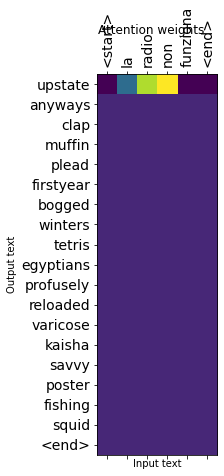

In [105]:
plot_attention(att, ita_sentence, res)

In [37]:
# def plot_attention(inp_sentence, att):
#   att = np.sum(att, axis=-1)
#   # plt.figure(figsize=(8,3))
#   # y_ticks = ita_sentence.split()
#   # len_sen = len(y_ticks)
#   # g = sns.barplot(y=list(range(len_sen)),x=att[:len_sen],palette="rocket_r",orient='h')
#   # g.set_yticklabels(y_ticks,rotation=0)
#   # plt.title("Attention Weights Plot for :"+ita_sentence)
#   # plt.show()

<font color='blue'>**Calculate BLEU score**</font>

In [77]:
def aveg_bleu_scores(test_data,n):
  sample_list = random.sample(range(len(test_data)),n)
  average_bleu = 0
  pred_data = []
  individual_bleu = []

  for i in sample_list:
    test_sentence, true_sentence = test_data.iloc[i,[0,1]]
    pred_sentence, att = predict(test_sentence)
    bleu_score = bleu.sentence_bleu([true_sentence.split()],pred_sentence.split())
    average_bleu += bleu_score

    # pred_data.append((true_sentence, pred_sentence))
    individual_bleu.append(bleu_score)
  
  return average_bleu/n, individual_bleu

In [78]:
#Create an object of your custom model.
#Compile and train your model on dot scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html
import nltk.translate.bleu_score as bleu
import random

test_df = validation.copy()
test_df = test_df[["italian","english_out"]]
test_df["english_out"] = test_df["english_out"].apply(lambda x: x.split("<end>")[0])

avg_score, individual_score = aveg_bleu_scores(test_df,50)
print(avg_score)
print(individual_score)

ValueError: ignored

## Model Training with General

In [ ]:
#Compile and train your model on general scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

<font color='blue'>**Repeat the same steps for Concat scoring function**</font>

In [ ]:
#Compile and train your model on concat scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

In [ ]:
# Write your observations on each of the scoring function